# PET processing for the new and improved data pipeline 

Steps involved:
1. Smoothing to remove/minimize PSF reconstruction artifacts, if any.
2. Intensity standardization -- 2 options: Clipping or histogram standardization
3. Data augmentation transform, including intensity stretching at high SUV levels.
4. Rescaling intensities to [0,1] - Min-max normalization, with min and max intensity values taken from the volume

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
# Settings 
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
standardization_method = 'clipping'  # 'clippling' or 'clipping+histogram'

## Comparing the differences in SUV range between the 2 of the most extreme PET volumes

Min and Max SUV: -5.0325503 71.97498


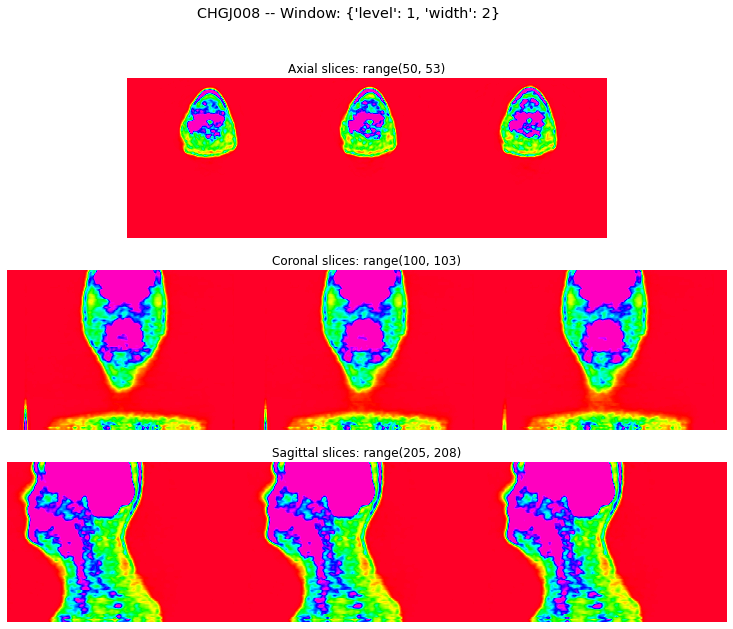

In [3]:
patient_1 = "CHGJ008"
PET_sitk = sitk.ReadImage(f"{data_dir}/{patient_1}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels
PET_np = sitk2np(PET_sitk, keep_whd_ordering=True)

print("Min and Max SUV:", PET_np.min(), PET_np.max())

window = {'level':1, 'width':2}
display_image(PET_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window=window,
               title=f"{patient_1} -- Window: {window}", cmap='gist_rainbow')

Min and Max SUV: -0.0009519125 1.2605579


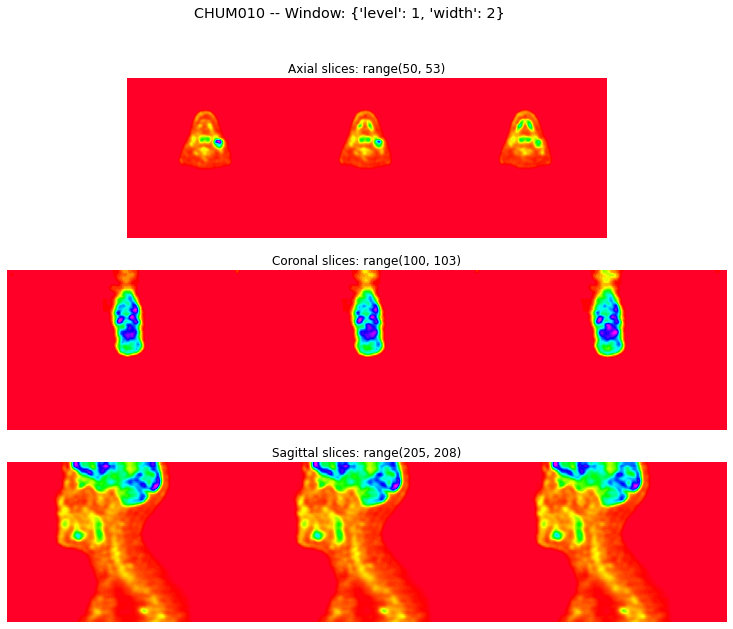

In [4]:
patient_2 = "CHUM010"
PET2_sitk = sitk.ReadImage(f"{data_dir}/{patient_2}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels
PET2_np = sitk2np(PET2_sitk, keep_whd_ordering=True)

print("Min and Max SUV:", PET2_np.min(), PET2_np.max())

window = {'level':1, 'width':2}
display_image(PET2_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window=window,
               title=f"{patient_2} -- Window: {window}", cmap='gist_rainbow')

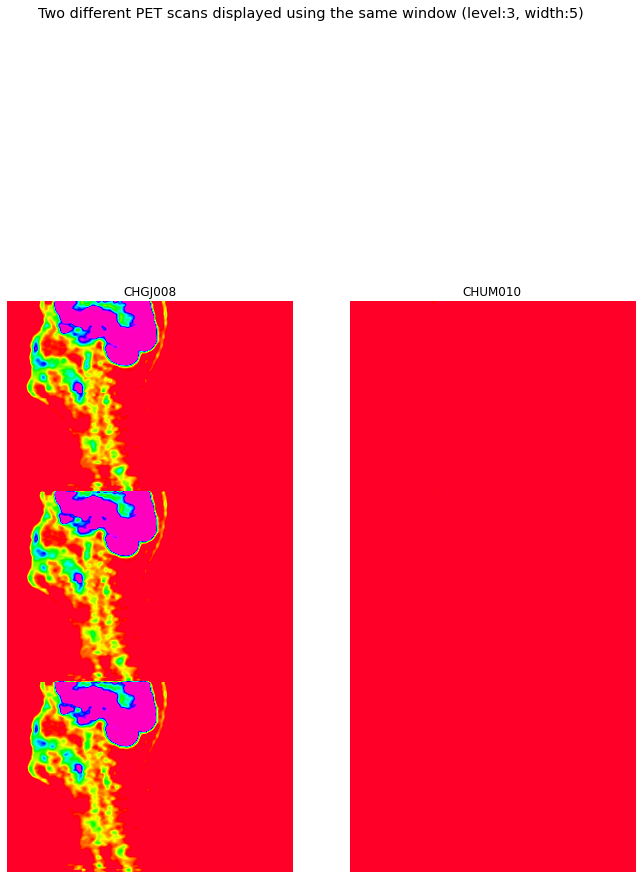

In [5]:
viz = NdimageVisualizer()
viz.multi_image_strips([PET_np, PET2_np],
                          modalities=['PET'] * 2,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=[patient_1, patient_2],
                          title="Two different PET scans displayed using the same window (level:3, width:5)")

## 1 Smoothing

In [6]:
t1 = time.time()
sigma = [2.0, 2.0, 2.0/3] # In format (W,H,D), Physical sigma of 2mm adjusted according to voxel spacing
PET_smooth_np = scipy.ndimage.gaussian_filter(PET_np, sigma=sigma)
time_diff = time.time() - t1

#print(f"Time taken for filtering: {time_diff:.2f}s")

print("Min and Max SUV:", PET_smooth_np.min(), PET_smooth_np.max())

Min and Max SUV: -0.60632825 28.235432


## 2 Standardizing the Intensities

In [7]:
PET_std_np = PET_smooth_np.copy()

if standardization_method == 'clipping':
    clipping_range = [0,20] # SUV
    #PET_std_np[PET_smooth_np < clipping_range[0]] = clipping_range[0]
    #PET_std_np[PET_smooth_np > clipping_range[1]] = clipping_range[1]
    PET_std_np = np.clip(PET_smooth_np, clipping_range[0], clipping_range[1])

elif standardization_method == 'clipping+histogram':
    # TODO
    pass

print("Min and Max SUV:", PET_std_np.min(), PET_std_np.max())

Min and Max SUV: 0.0 20.0


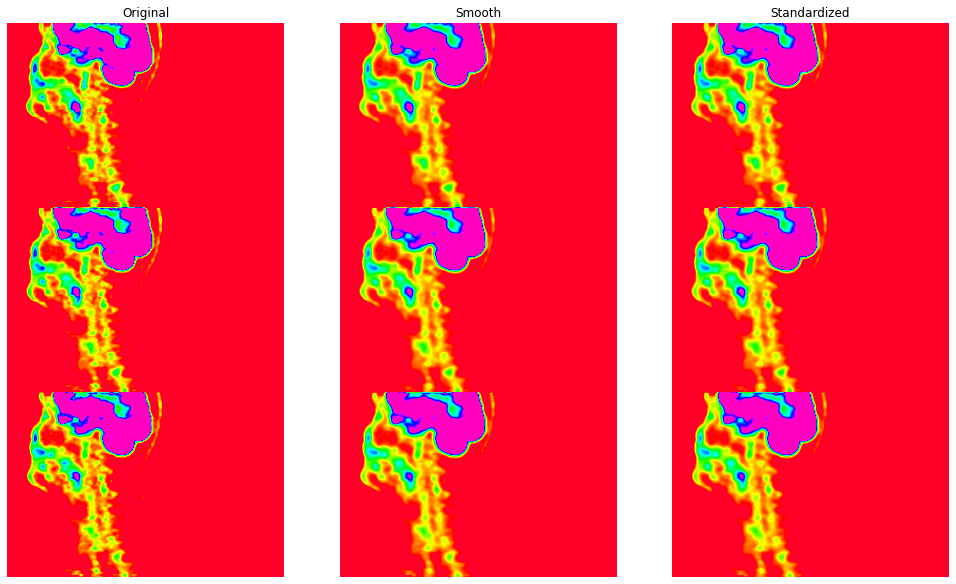

In [8]:
viz.multi_image_strips([PET_np, PET_smooth_np, PET_std_np],
                          modalities=['PET'] * 3,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Original", "Smooth", "Standardized"])

## 3 Data Augmentation

### 3.1 Intensity stretching

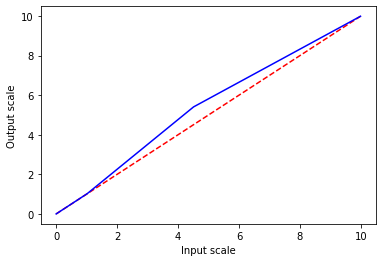

In [9]:
# Conceptual example on dummy data --

input_scale = np.arange(0, 10, 0.01)
output_scale = input_scale.copy()
max_val = max(input_scale)

# Dummy percentile values
pc30 = 1
pc95 = 4.5

pc95_increase_factor = 1.2

# Stretch the contrast in range [pc30, pc95)
mask = (input_scale>=pc30) & (input_scale<pc95)
output_scale[mask] = (input_scale[mask]-pc30)/(pc95-pc30) * (pc95_increase_factor*pc95-pc30) + pc30

# Squeeze the contrast in range [pc95, max]
mask = (input_scale>=pc95) & (input_scale<=max_val)
output_scale[mask] = (input_scale[mask]-pc95)/(max_val-pc95) * (max_val-pc95_increase_factor*pc95) + pc95_increase_factor*pc95


plt.plot(input_scale, input_scale, 'r--')
plt.plot(input_scale, output_scale, 'b')
plt.xlabel("Input scale")
plt.ylabel("Output scale")
plt.show()

In [10]:
# Applying to PET -- stretch the contrast in the range between 30 percentile and 95 percentile 

t1 = time.time()

pc30 = np.percentile(PET_std_np, 30)
pc95 = np.percentile(PET_std_np, 95)
max_suv = PET_std_np.max()

print("30 percentile:", pc30)
print("95 percentile:", pc95)

pc95_increase_factor = 1.2

PET_stretched_np = PET_std_np.copy()

# Stretch the contrast in range [pc30, pc95)
mask = (PET_std_np >= pc30) & (PET_std_np < pc95)
PET_stretched_np[mask] = (PET_std_np[mask]-pc30)/(pc95-pc30) * (pc95_increase_factor*pc95-pc30) + pc30

# Squeeze the contrast in range [pc95, max]
mask = (PET_std_np >= pc95) & (PET_std_np <= 255)
PET_stretched_np[mask] = (PET_std_np[mask]-pc95)/(max_suv-pc95) * (max_suv-pc95_increase_factor*pc95) + pc95_increase_factor*pc95


30 percentile: 0.002518667606636882
95 percentile: 1.3996523857116703


### 3.2 Random rotation

In [11]:
affine_matrix = np.array([[1,0,0,0],  # Affine matrix that encodes the spacing (1,1,3) as 3x scaling/zoom along z-axis
                          [0,1,0,0],
                          [0,0,3,0],
                          [0,0,0,1]])

PET_tio = torchio.Image(tensor=np.expand_dims(PET_std_np,axis=0), type=torchio.INTENSITY, affine=affine_matrix)
print("Spacing:", PET_tio.spacing) # Check the spacing

subject = torchio.Subject({'PET':PET_tio})

Spacing: (1.0, 1.0, 3.0)


In [12]:
rotation_transform = torchio.RandomAffine(scales=(1,1), degrees=(-10,10), translation=(0,0))

t1 = time.time()
PET_rot_np = rotation_transform(subject).get_images_dict()['PET'].numpy().squeeze()
print(f"Time taken: {time.time()-t1:2f}s")

Time taken: 4.980566s


### 3.3 Random scaling (no change in image size)

In [13]:
scaling_transform = torchio.RandomAffine(scales=(0.85,1.15), degrees=(0,0), translation=(0,0))

t1 = time.time()
PET_scl_np = scaling_transform(subject).get_images_dict()['PET'].numpy().squeeze()
print(f"Time taken: {time.time()-t1:2f}s")

Time taken: 1.433825s


### 3.4 Elastic distortion

In [14]:
elastic_transform = torchio.RandomElasticDeformation(num_control_points=(5,5,5), max_displacement=(20,20,20), locked_borders=2)

t1 = time.time()
PET_elastic_np = elastic_transform(subject).get_images_dict()['PET'].numpy().squeeze()
print(f"Time taken: {time.time()-t1:2f}s")

Time taken: 31.675543s


Min and max SUV: 0.0 20.0
Min and max SUV: 0.0 20.0
Min and max SUV: 0.0 17.378433
Min and max SUV: 0.0 20.0


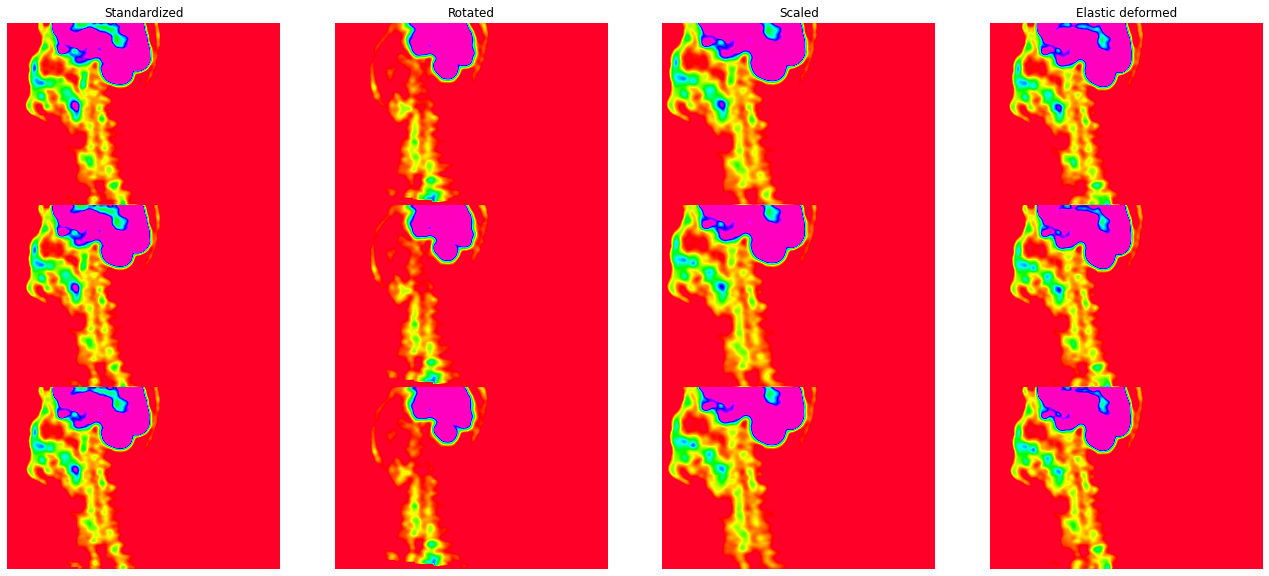

In [15]:
print("Min and max SUV:", PET_std_np.min(), PET_std_np.max())
print("Min and max SUV:", PET_rot_np.min(), PET_rot_np.max())
print("Min and max SUV:", PET_scl_np.min(), PET_scl_np.max())
print("Min and max SUV:", PET_elastic_np.min(), PET_elastic_np.max())

viz.multi_image_strips([PET_std_np, PET_rot_np, PET_scl_np, PET_elastic_np],
                          modalities=['PET'] * 4,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["Standardized", "Rotated", "Scaled", "Elastic deformed"])

## 4 Rescaling intensities to [0,1]

In [16]:
PET_norm_np = (PET_std_np - PET_std_np.min()) / (PET_std_np.max() - PET_std_np.min())